In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression



def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



In [2]:
df = pd.read_csv(
    "data/train.csv"
    , parse_dates=['date']
    , infer_datetime_format=True)
df = df.set_index('date').to_period('D')
df = df.set_index(['store_nbr', 'family'], append=True)
average_sales = df.groupby('date').mean()['sales']
average_sales = average_sales.to_frame()

#opvullen lege data 
idx = pd.date_range('2013-01-01', '2017-08-15')
average_sales.index = average_sales.index.to_timestamp()
average_sales = average_sales.reindex(idx, fill_value=0)
average_sales.index = average_sales.index.to_period("D")

average_sales.index = average_sales.index.rename("date")




In [3]:
average_sales['Time'] = np.arange(len(average_sales.index) + 1687)

In [4]:
average_sales

,sales,Time
date,,
2013-01-01,1.409438,0
2013-01-02,278.390807,1
2013-01-03,202.840197,2
2013-01-04,198.911154,3
2013-01-05,267.873244,4
...,...,...
2017-08-11,463.733851,1683
2017-08-12,444.798280,1684
2017-08-13,485.768618,1685


<AxesSubplot:xlabel='Time', ylabel='sales'>

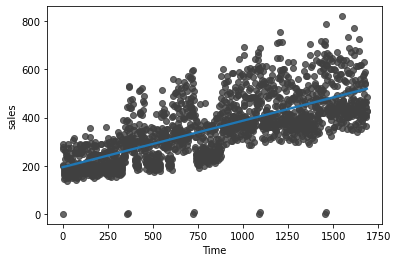

In [5]:
sns.regplot(x=average_sales.Time, y=average_sales.sales, scatter_kws=dict(color='0.25'))

In [6]:
average_sales['Lag_1'] = average_sales['sales'].shift(1)

<AxesSubplot:xlabel='Lag_1', ylabel='sales'>

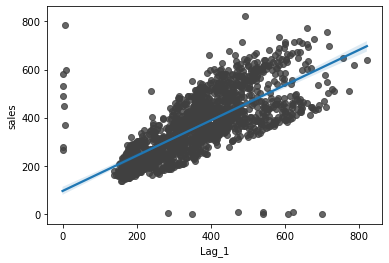

In [7]:
sns.regplot(x="Lag_1", y="sales", data=average_sales, scatter_kws=dict(color='0.25'))

In [8]:
X = average_sales[["Lag_1"]].dropna()
y = average_sales.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')

In [9]:
model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

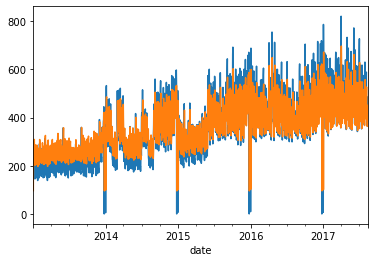

In [10]:
ax = y.plot()
ax = y_pred.plot(ax=ax)

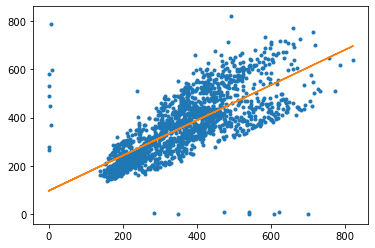

In [11]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.')
ax.plot(X['Lag_1'], y_pred)

In [12]:
average_sales.head()

,sales,Time,Lag_1
date,,,
2013-01-01,1.409438,0,NaN
2013-01-02,278.390807,1,1.409438
2013-01-03,202.840197,2,278.390807
2013-01-04,198.911154,3,202.840197
2013-01-05,267.873244,4,198.911154


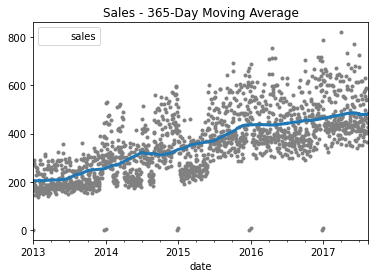

In [13]:
moving_average = average_sales[['sales']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=180,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = average_sales[['sales']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

In [14]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
y = average_sales["sales"]
X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [15]:
from sklearn.linear_model import LinearRegression


# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

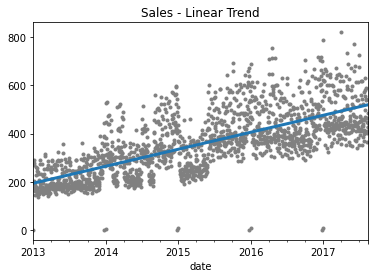

In [16]:
ax = y.plot(style=".", color="0.5", title="Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [17]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2017-08-16    520.133758
2017-08-17    520.327015
2017-08-18    520.520272
2017-08-19    520.713530
2017-08-20    520.906787
Freq: D, dtype: float64

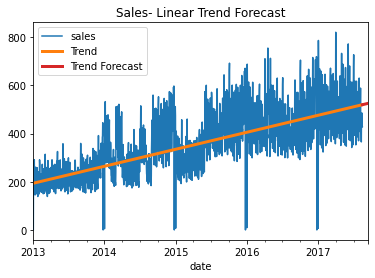

In [18]:
ax = y.plot(title="Sales- Linear Trend Forecast")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

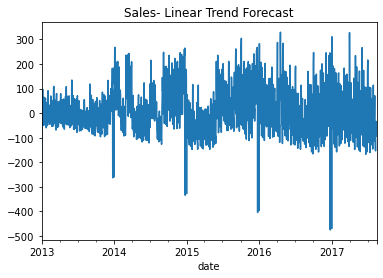

In [19]:
y_detrended = y - y_pred

ax = y_detrended.plot(title="Sales- Linear Trend Forecast")


In [20]:
avg_sales = average_sales.copy()




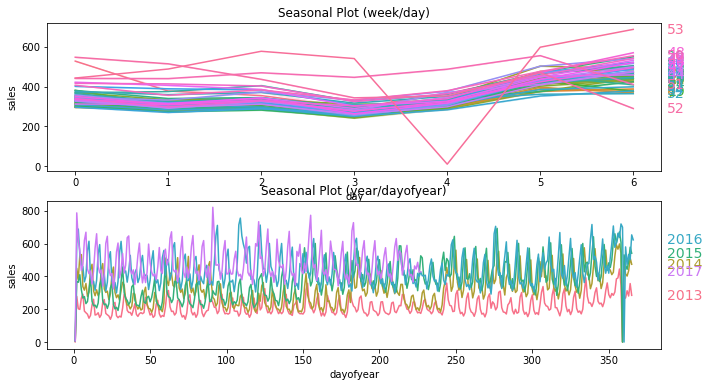

In [21]:
avg_sales['day'] = avg_sales.index.dayofweek
avg_sales['week'] = avg_sales.index.week

avg_sales["dayofyear"] = avg_sales.index.dayofyear
avg_sales["year"] = avg_sales.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(avg_sales, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(avg_sales, y="sales", period="year", freq="dayofyear", ax=ax1);

C:\Users\Tijs\AppData\Local\Temp/ipykernel_37088/2787331691.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(avg_sales.sales);


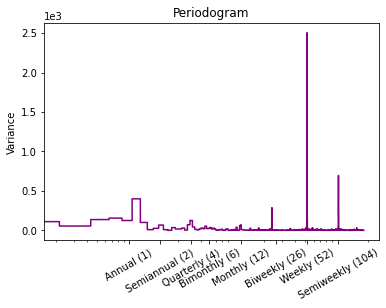

In [22]:
plot_periodogram(avg_sales.sales);

In [23]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="M", order=4)  

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

avg_sales_season = dp.in_sample()

In [24]:
model = LinearRegression(fit_intercept=False)
model.fit(avg_sales_season, y)

y_pred_season = pd.Series(model.predict(avg_sales_season), index=avg_sales_season.index)



X = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()




2017-08-16    491.011414
2017-08-17    445.655114
2017-08-18    488.838990
2017-08-19    598.338996
2017-08-20    625.550925
Freq: D, dtype: float64

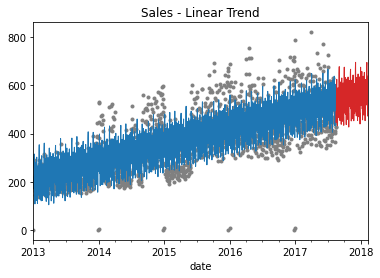

In [25]:
ax = y.plot(style=".", color="0.5", title="Sales - Linear Trend")
ax = y_pred_season.plot(ax=ax, linewidth=1, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=1, label="Trend Forecast", color="C3")

C:\Users\Tijs\AppData\Local\Temp/ipykernel_37088/1155334974.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax1 = plot_periodogram(y, ax=ax1)
C:\Users\Tijs\AppData\Local\Temp/ipykernel_37088/1155334974.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax2 = plot_periodogram(y_deseason, ax=ax2);


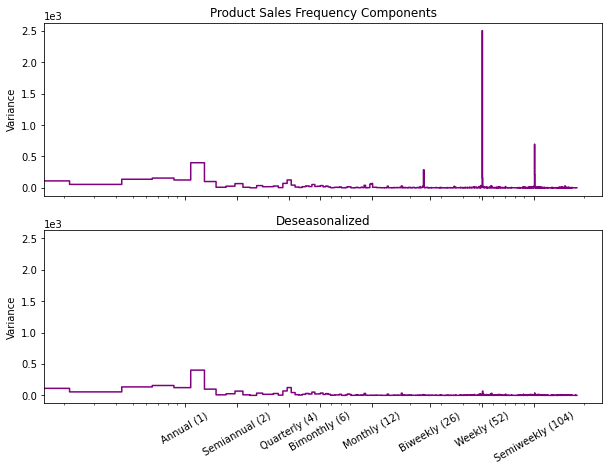

In [26]:
y_deseason = y - y_pred_season

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [27]:
#Holidays!
holidays_events = pd.read_csv("data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')


holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2013':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)




In [28]:
#opvullen lege data 
#idx = pd.date_range('2013-01-01', '2017-08-15')
#y_deseason.index = y_deseason.index.to_timestamp()
#y_deseason = y_deseason.reindex(idx, fill_value=0)
#y_deseason.index = y_deseason.index.to_period("D")

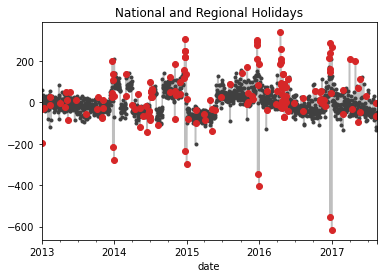

In [29]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [130]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),  # optional,  but nice to have
)

X2 = average_sales.join(X_holidays, on='date').fillna(0.0)

y = X2.loc[:, 'sales']  # target
y, X2 = y.align(X2, join='inner')



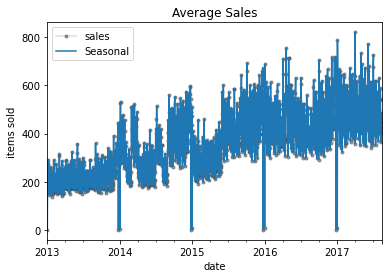

In [31]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [32]:
X2

,sales,Time,Lag_1,Primer dia del ano,Recupero puente Navidad,Recupero puente primer dia del ano,Carnaval,Provincializacion de Cotopaxi,Viernes Santo,Dia del Trabajo,...,Terremoto Manabi+26,Terremoto Manabi+27,Terremoto Manabi+28,Terremoto Manabi+29,Terremoto Manabi+30,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Puente Dia de Difuntos,Recupero Puente Dia de Difuntos,Traslado Primer dia del ano
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.409438,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,278.390807,1,1.409438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,202.840197,2,278.390807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,198.911154,3,202.840197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,267.873244,4,198.911154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,463.733851,1683,365.536988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,444.798280,1684,463.733851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,485.768618,1685,444.798280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
# Create training data
fourier = CalendarFourier(freq='M', order=6)
dp = DeterministicProcess(
    index=X2.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

final = X2.join(X, on='date').fillna(0.0)
y = final.loc[:, 'sales']  # target
y, final = y.align(final, join='inner')

final = final.drop(['sales', 'Lag_1'], axis=1)

model = LinearRegression(fit_intercept=False)
model.fit(final, y)
y_pred = pd.DataFrame(model.predict(final), index=final.index)


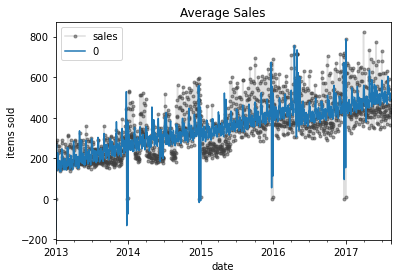

In [192]:

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [193]:
Xfore = dp.out_of_sample(180)

Xfore.tail()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)","sin(5,freq=M)","cos(5,freq=M)","sin(6,freq=M)","cos(6,freq=M)"
2018-02-07,1.0,1869.0,0.0,0.0,0.0,0.0,0.0,1.0,0.974928,2.225209e-01,4.338837e-01,-0.900969,-0.781831,-6.234898e-01,-7.818315e-01,0.623490,0.433884,9.009689e-01,9.749279e-01,-0.222521
2018-02-08,1.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,6.123234e-17,1.224647e-16,-1.000000,-1.000000,-1.836970e-16,-2.449294e-16,1.000000,1.000000,3.061617e-16,3.673940e-16,-1.000000
2018-02-09,1.0,1871.0,1.0,0.0,0.0,0.0,0.0,0.0,0.974928,-2.225209e-01,-4.338837e-01,-0.900969,-0.781831,6.234898e-01,7.818315e-01,0.623490,0.433884,-9.009689e-01,-9.749279e-01,-0.222521
2018-02-10,1.0,1872.0,0.0,1.0,0.0,0.0,0.0,0.0,0.900969,-4.338837e-01,-7.818315e-01,-0.623490,-0.222521,9.749279e-01,9.749279e-01,-0.222521,-0.623490,-7.818315e-01,-4.338837e-01,0.900969
2018-02-11,1.0,1873.0,0.0,0.0,1.0,0.0,0.0,0.0,0.781831,-6.234898e-01,-9.749279e-01,-0.222521,0.433884,9.009689e-01,4.338837e-01,-0.900969,-0.974928,2.225209e-01,7.818315e-01,0.623490


In [194]:
Xfore['NewYear'] = (Xfore.index.dayofyear == 1)
Xfore.index = Xfore.index.rename("date")

In [195]:

holidaysfore = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017-08-15':'2018-02-11', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)




X_holidaysfore = pd.DataFrame(
    ohe.transform(holidaysfore),
    index=holidaysfore.index,
    columns=ohe.categories_[0],
     # optional,  but nice to have
)


In [196]:
ohe.categories_[0]

array(['Batalla de Pichincha', 'Black Friday', 'Carnaval', 'Cyber Monday',
       'Dia de Difuntos', 'Dia de la Madre', 'Dia de la Madre-1',
       'Dia del Trabajo', 'Inauguracion Mundial de futbol Brasil',
       'Independencia de Cuenca', 'Independencia de Guayaquil',
       'Mundial de futbol Brasil: Cuartos de Final',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Final',
       'Mundial de futbol Brasil: Octavos de Final',
       'Mundial de futbol Brasil: Semifinales',
       'Mundial de futbol Brasil: Tercer y cuarto lugar', 'Navidad',
       'Navidad+1', 'Navidad-1', 'Navidad-2', 'Navidad-3', 'Navidad-4',
       'Primer Grito de Independencia', 'Primer dia del ano',
       'Primer dia del ano-1', 'Provincializacion Santa Elena',
       'Provincializacion de Cotopaxi', 'Provincializacion de Imbabura',
       'Provincializacion de Santo Do

In [197]:
final2 = Xfore.join(X_holidaysfore, on='date').fillna(0.0)

final2['Time'] = np.arange(len(final2.index)) + 1688

In [198]:
final2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo,Time
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1694.0,0.0,0.0,0.0,0.0,0.0,1.0,0.101168,-9.948693e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1688
2017-08-17,1.0,1695.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101168,-9.948693e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1689
2017-08-18,1.0,1696.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.299363,-9.541393e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1690
2017-08-19,1.0,1697.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.485302,-8.743466e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1691
2017-08-20,1.0,1698.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.651372,-7.587581e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-07,1.0,1869.0,0.0,0.0,0.0,0.0,0.0,1.0,0.974928,2.225209e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1863
2018-02-08,1.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,6.123234e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1864
2018-02-09,1.0,1871.0,1.0,0.0,0.0,0.0,0.0,0.0,0.974928,-2.225209e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1865


In [203]:


final2 = final2.reindex(columns=final.columns)

y_fore = pd.Series(model.predict(final2), index=final2.index)




In [212]:
pd.set_option('display.max_rows', y_fore.shape[0]+1)
y_fore

date
2017-08-16    5.464490e+02
2017-08-17    5.231474e+02
2017-08-18    4.994734e+02
2017-08-19    5.116816e+02
2017-08-20    5.257667e+02
2017-08-21    4.973265e+02
2017-08-22    5.188062e+02
2017-08-23    5.293649e+02
2017-08-24    4.960977e+02
2017-08-25    4.736778e+02
2017-08-26    4.926652e+02
2017-08-27    5.101429e+02
2017-08-28    4.826704e+02
2017-08-29    5.140279e+02
2017-08-30    5.510362e+02
2017-08-31    5.531462e+02
2017-09-01    5.575952e+02
2017-09-02    5.840328e+02
2017-09-03    5.923799e+02
2017-09-04    5.494252e+02
2017-09-05    5.611952e+02
2017-09-06    5.689251e+02
2017-09-07    5.322872e+02
2017-09-08    5.017193e+02
2017-09-09    5.122674e+02
2017-09-10    5.261237e+02
2017-09-11    4.962547e+02
2017-09-12    5.172187e+02
2017-09-13    5.329595e+02
2017-09-14    5.116988e+02
2017-09-15    5.027607e+02
2017-09-16    5.295394e+02
2017-09-17    5.464460e+02
2017-09-18    5.117216e+02
2017-09-19    5.296492e+02
2017-09-20    5.446165e+02
2017-09-21    5.167349e

In [215]:
y_fore['2018-01-01']

0.0

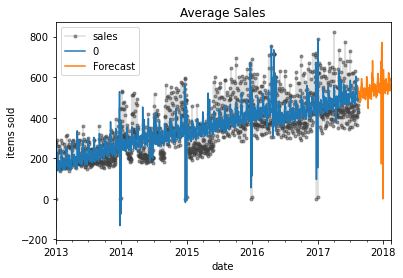

In [217]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal fit")
ax = y_fore.plot(ax=ax, label="Forecast")
ax.legend();

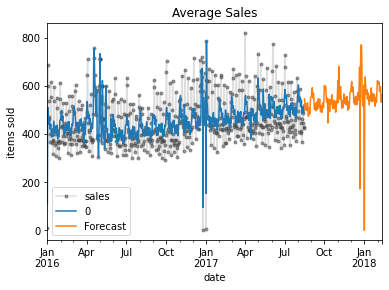

In [220]:
ax = y.loc['2016':].plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.loc['2016':].plot(ax=ax, label="Seasonal fit")
ax = y_fore.loc['2016':].plot(ax=ax, label="Forecast")
ax.legend();